In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import random
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns


physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

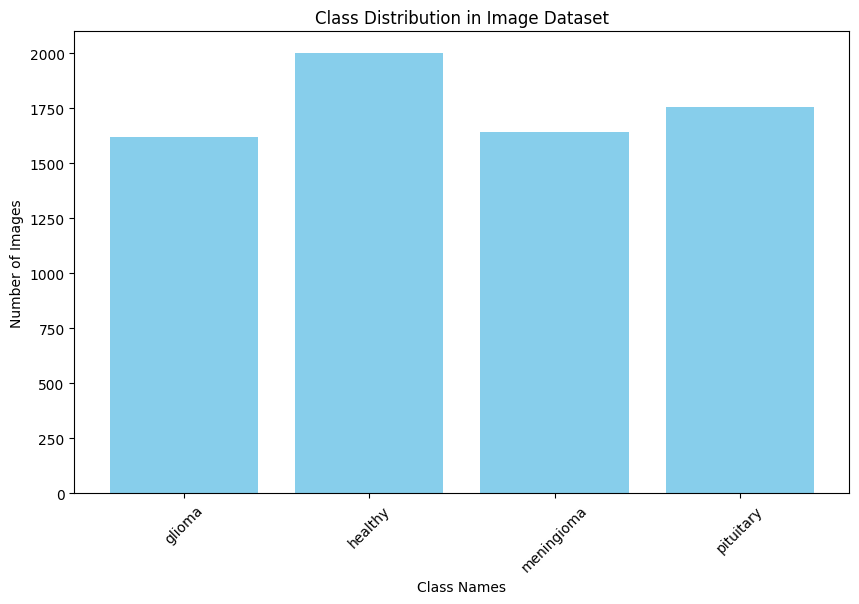

In [18]:
dir = 'C:\\Users\\User\\Downloads\\raw_img'

# Get the class names (subfolder names)
class_names = os.listdir(dir)

# Count the number of images in each class folder
class_counts = {class_name: len(os.listdir(os.path.join(dir, class_name))) for class_name in class_names}

# Plotting the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Class Distribution in Image Dataset')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [19]:
import os
import shutil
import random

base_dir = 'data'  # Base directory to create train, val, and test folders

# Define classes
classes = ['pituitary', 'meningioma', 'healthy', 'glioma']

# Create directories for train, val, and test
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2  # Ensure these ratios sum up to 1

# Split images
for class_name in classes:
    class_dir = os.path.join(dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)  # Shuffle images for randomness

    num_images = len(images)
    train_count = int(num_images * train_ratio)
    val_count = int(num_images * val_ratio)

    # Move images to respective directories
    for i, image in enumerate(images):
        src = os.path.join(class_dir, image)
        if i < train_count:
            dst = os.path.join(base_dir, 'train', class_name, image)
            shutil.copyfile(src, dst)
        elif i < train_count + val_count:
            dst = os.path.join(base_dir, 'val', class_name, image)
            shutil.copyfile(src, dst)
        else:
            dst = os.path.join(base_dir, 'test', class_name, image)
            shutil.copyfile(src, dst)

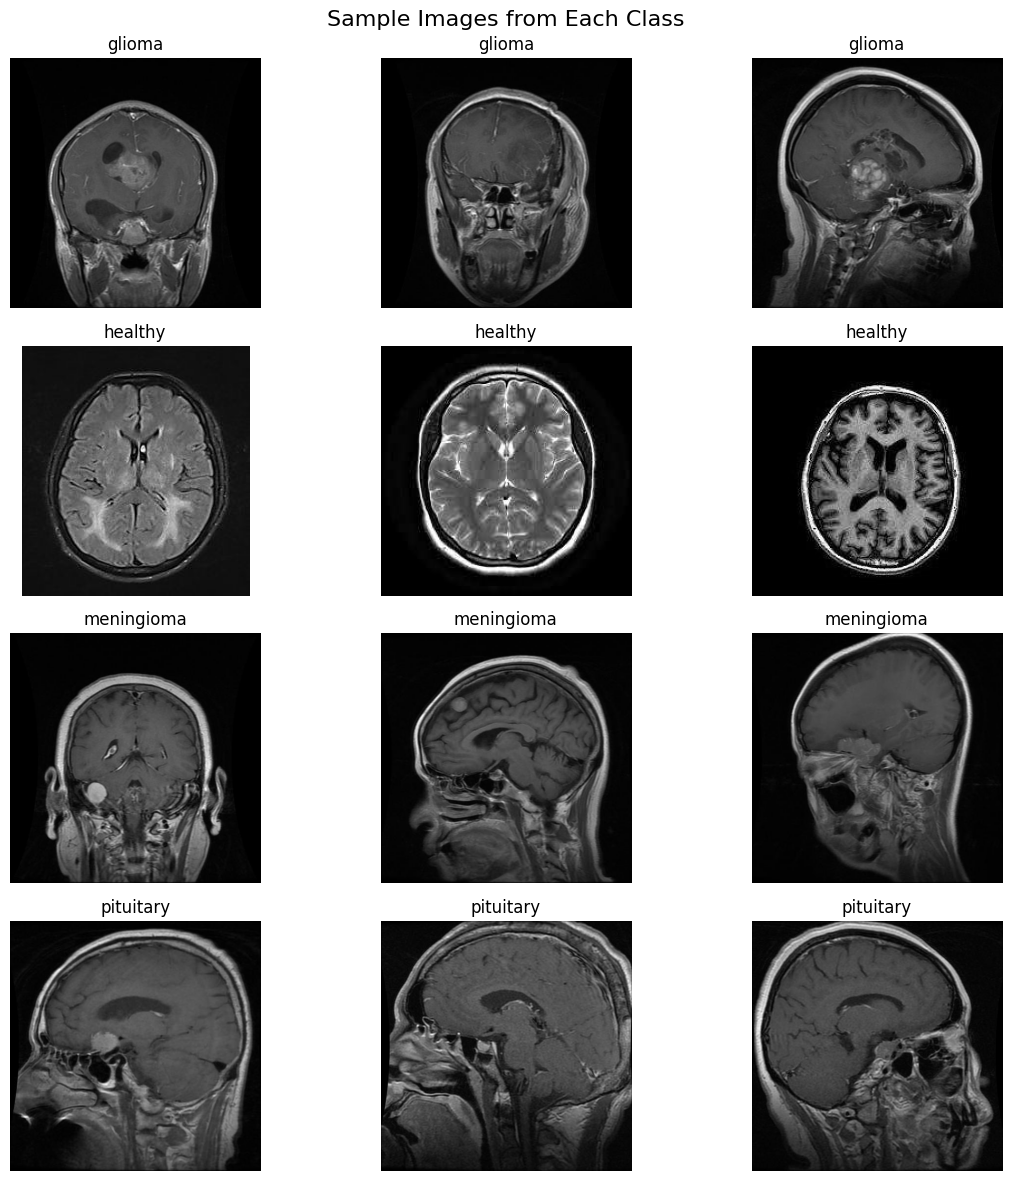

In [20]:
# Sample Images Visualization
plt.figure(figsize=(12, 12))
for i, class_name in enumerate(class_names):
    # Get a list of image paths in the class directory
    class_dir = os.path.join(dir, class_name)
    image_files = os.listdir(class_dir)
    
    # Randomly select a few images from each class
    sample_images = random.sample(image_files, 3)
    
    for j, img_file in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path)
        
        plt.subplot(len(class_names), 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)

plt.suptitle('Sample Images from Each Class', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224) 
BATCH_SIZE = 16

# Create an instance of ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,          # Normalize pixel values to range [0,1]
    rotation_range=20,        # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,    # Shift the image horizontally by up to 20%
    height_shift_range=0.2,   # Shift the image vertically by up to 20%
    shear_range=0.2,          # Shear angle in counter-clockwise direction in degrees
    zoom_range=0.2,           # Random zoom in
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill mode for points outside the boundaries
)

# Create a separate ImageDataGenerator for validation and testing (no augmentation)
val_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),    # Directory with training images
    target_size=IMG_SIZE,    # Resize images to match InceptionV3 input size
    batch_size=BATCH_SIZE,    # Batch size for training
    class_mode='categorical'  # Output labels will be one-hot encoded (multi-class)
)

# Load images from the directory structure for validation
val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),      # Directory with validation images
    target_size=IMG_SIZE,    # Resize validation images
    batch_size=BATCH_SIZE,
    class_mode='categorical' # One-hot encoded labels for validation
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data
)

# Checking the class indices
print("Class indices:", train_generator.class_indices)

Found 6371 images belonging to 4 classes.
Found 1331 images belonging to 4 classes.
Found 2543 images belonging to 4 classes.
Class indices: {'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}


In [40]:
from tensorflow.keras import layers, models

# Load the pre-trained ResNet50 model + higher level layers
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',      # Use weights pre-trained on ImageNet
    include_top=False,       # Exclude the top fully connected layers
    input_shape=(128, 128, 3)  # Input shape for ResNet
)

# Unfreeze some of the deeper layers (closer to the output)
for layer in base_model.layers[-10:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Add new layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global Average Pooling
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),                # Dropout for regularization
    layers.Dense(4, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
    
# Display the model architecture
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_17  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_34 (Dense)            (None, 128)               262272    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 4)                 516       
                                                                 
Total params: 23,850,500
Trainable params: 23,797,380
Non-trainable params: 53,120
____________________________________

In [45]:
class PrintLearningRateCallback(tf.keras.callbacks.Callback):
    def __init__(self, batch_interval=100):
        super(PrintLearningRateCallback, self).__init__()
        self.batch_interval = batch_interval

    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        print(f"\nStarting Epoch {epoch+1}, Learning Rate: {lr.numpy()}")

    def on_train_batch_end(self, batch, logs=None):
        if batch % self.batch_interval == 0:
            print(f"Batch {batch}: loss = {logs['loss']:.4f}, accuracy = {logs['accuracy']:.4f}")
        
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=3):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0  # Reset wait time
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nStopping training early after {epoch + 1} epochs!")
                self.model.stop_training = True
                
class SaveBestModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super(SaveBestModelCallback, self).__init__()
        self.best_acc = 0.0
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            print(f"\nEpoch {epoch+1}: Validation accuracy improved to {val_acc:.4f}, saving model.")
            self.model.save(self.save_path)

In [46]:
save_best_model = SaveBestModelCallback(save_path="best_model.h5")
callbacks = [PrintLearningRateCallback(),CustomEarlyStopping(patience=2),save_best_model]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=10,  # Adjust the number of epochs as needed
    callbacks = callbacks
)


Starting Epoch 1, Learning Rate: 0.0010000000474974513
Epoch 1/10
Batch 0: loss = 0.5754, accuracy = 0.8125
398/398 [==============================] - ETA: 0s - loss: 0.5206 - accuracy: 0.8126
Epoch 1: Validation accuracy improved to 0.3592, saving model.
398/398 [==============================] - 180s 452ms/step - loss: 0.5206 - accuracy: 0.8126 - val_loss: 4.0913 - val_accuracy: 0.3592

Starting Epoch 2, Learning Rate: 0.0010000000474974513
Epoch 2/10
Batch 0: loss = 0.4686, accuracy = 0.8125
398/398 [==============================] - ETA: 0s - loss: 0.4800 - accuracy: 0.8349
Epoch 2: Validation accuracy improved to 0.5873, saving model.
398/398 [==============================] - 179s 449ms/step - loss: 0.4800 - accuracy: 0.8349 - val_loss: 2.0479 - val_accuracy: 0.5873

Starting Epoch 3, Learning Rate: 0.0010000000474974513
Epoch 3/10
Batch 0: loss = 0.4727, accuracy = 0.7500
398/398 [==============================] - ETA: 0s - loss: 0.3848 - accuracy: 0.8607
Epoch 3: Validation ac

In [9]:
model = tf.keras.models.load_model("best_model.h5")
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

159/159 [==============================] - 22s 131ms/step - loss: 0.2115 - accuracy: 0.9198
Test Loss: 0.21154046058654785
Test Accuracy: 0.9197797775268555


159/159 [==============================] - 21s 127ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.79      0.88       583
     healthy       0.97      0.98      0.98       724
  meningioma       0.79      0.93      0.85       595
   pituitary       0.94      0.96      0.95       641

    accuracy                           0.92      2543
   macro avg       0.93      0.92      0.92      2543
weighted avg       0.93      0.92      0.92      2543



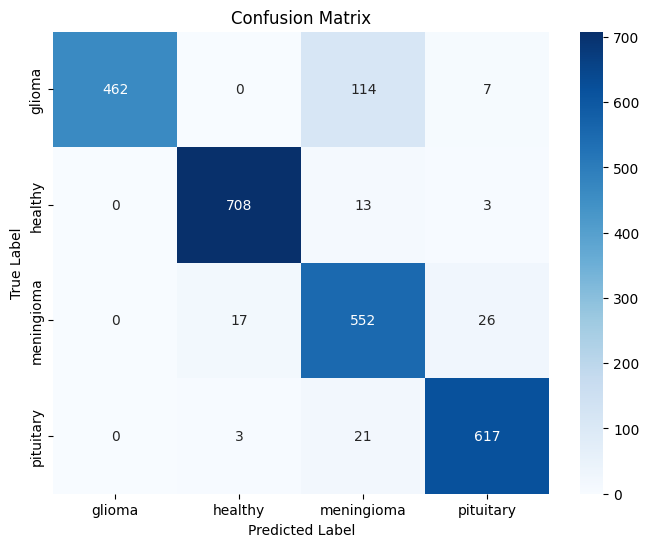

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions from the model
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get the true labels
y_true = test_generator.classes

# Get class labels for reference
class_labels = list(test_generator.class_indices.keys())

# Generate a classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()